<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Search Engine

by Fabian Märki

## Summary
The aim of this notebook is to build a Search Engine based on TF-IDF.

## Links
- [Build your semantic document search engine with TF-IDF and Google-USE](https://medium.com/analytics-vidhya/build-your-semantic-document-search-engine-with-tf-idf-and-google-use-c836bf5f27fb)
- [Passende Antwort: Neuronale Suche und Question Answering](https://www.heise.de/hintergrund/Passende-Antwort-Neuronale-Suche-und-Question-Answering-7127798.html)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2024_FS_CAS_NLP_LAB_Notebooks/blob/master/XX_a_Search_Engine.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe


import pandas as pd
import numpy as np

In [2]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-46-generic
Python version: 3.6.9
CPU cores: 6
RAM: 31.12GB total and 27.71GB available
Tensorflow version: 2.5.1
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


Download data and load it into a pandas dataframe.

In [3]:
%%time
download("https://drive.switch.ch/index.php/s/PrVg8Ugfc2jDwT3/download", "data/german_doctor_reviews_original.parq")
data = load_dataframe("data/german_doctor_reviews_original.parq")
data.shape

CPU times: user 783 ms, sys: 207 ms, total: 991 ms
Wall time: 1.09 s


(357899, 2)

In [4]:
data.head(3)

,text_original,rating
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0


Check if notebook runs on colab and reduce model size (RAM is the limiting factor on Colab)

In [5]:
from fhnw.nlp.utils.colab import runs_on_colab

if runs_on_colab():
    data = data.head(100000)

  
We can use [scikit-learn's](https://scikit-learn.org/stable) [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to create a vocabulary from the text and compute the Term Frequency - Inverse Document Frequency (TF-IDF). 
The result is a sparse matrix representation of the TF-IDF, meaning each column represents a word in the vocabulary and each row represents the document in the dataset where the values are the TF-IDFs. Note that with this representation, TF-IDFs of some words can be 0 (therefore a sprase matrix) if the word did not appear in the corresponding document.

It is important to note that the TF-IDF should be based on a large corpora and should be representative for the texts you want to extract keywords.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [7]:
%%time

tfidf = TfidfVectorizer (max_df=0.85, min_df=3)
word_count_vector = tfidf.fit_transform(data["text_original"])

CPU times: user 15.7 s, sys: 222 ms, total: 15.9 s
Wall time: 15.9 s


Let's look at some words from our vocabulary...

In [8]:
mask = pd.Series(tfidf.get_feature_names_out()).str.startswith("behandlungsschritt")
pd.Series(tfidf.get_feature_names_out())[mask]

8348      behandlungsschritt
8349     behandlungsschritte
8350    behandlungsschritten
8351    behandlungsschrittes
dtype: object

<font color='blue'>**But wait, does it make sense to have individual words like 'behandlungsschritt', 'behandlungsschritte' 'behandlungsschritten', 'behandlungsschrittes' etc. in a TF-IDF (in a bag-of-words) model?**</font>

<font color='red'>**TASK: Implement the function `preprocess` below in such a way that words with the "same meaning" colaps into one token.**</font>

In [9]:
from bs4 import BeautifulSoup
from compound_split import doc_split
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize

nltk.download('punkt')

stemmer = SnowballStemmer("german")

def preprocess(text):
    """Preprocesses the text (text cleaning, tokenization, compound word splitting, stemming, stop word removal)

    Parameters
    ----------
    text : str
        The text to preprocess
        
    Returns
    -------
    list
        The preprocessed and tokenized text
    """
    # TODO: !!! add your code !!!
    #############################
    # !!! this needs rework !!!
    # this code just tokenized the text (see below for steps you could implement)
    from nltk.tokenize import word_tokenize
    word_tokens = word_tokenize(text)
    
    # remove html tags
    
    # tokenize words
    
    # split compound words
    
    # apply stemming
    
    # lowercase words

    return word_tokens



# TODO: !!! add your code !!!
#############################
#
# Prepare stopwords here

from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stopwords = set(stopwords.words("german"))

# analyze and revise stopwords
# add semantically empty words (in the given context)
stopwords.add("frau")
stopwords.add("dr")
stopwords.add("herr")
stopwords.add("herrn")
stopwords.add("fr")
stopwords.add("werden")

# remove semantically meaningful words (like e.g. nicht)
stopwords.remove("nicht")
stopwords.remove("kein")

###################
# TODO: !!! end !!!

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# test if preprocess works

# test html tag removal and stemming of beste
print(preprocess("<br> Dies ist der beste Arzt!"))
# test stemming of schlechteste
print(preprocess("Dies ist der schlechteste Arzt!"))
print(preprocess("Ein schlechter Arzt!"))
# ensure "nicht" is not removed (in case stopwords are used) - otherwise both sentences have the same representation (despite oposite meaning)
print(preprocess("Dieser Arzt ist gut!"))
print(preprocess("Dieser Arzt ist nicht gut!"))
# test if compound words are split (optional)
print(preprocess("Behandlungsablauf Behandlungsablaufes Behandlungsablaufs Behandlungsabläufe Behandlungsabläufen"))
# test is sentences (without whitespace) are split
print(preprocess("Der beste Behandlungsablauf.Es war grossartig."))

['best', 'arzt', '!']
['schlecht', 'arzt', '!']
['schlecht', 'arzt', '!']
['arzt', 'gut', '!']
['arzt', 'nicht', 'gut', '!']
['behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf']
['best', 'behandl', 'ablauf', '.', 'grossart', '.']


In [11]:
from fhnw.nlp.utils.preprocess import preprocess

In [12]:
# test html tag removal and stemming of beste
print(preprocess("<br> Dies ist der beste Arzt!", stopwords=stopwords, do_compound_word_split=True))
# test stemming of schlechteste
print(preprocess("Dies ist der schlechteste Arzt!", stopwords=stopwords, do_compound_word_split=True))
print(preprocess("Ein schlechter Arzt!", stopwords=stopwords, do_compound_word_split=True))
# ensure "nicht" is not removed (in case stopwords are used) - otherwise both sentences have the same representation (despite oposite meaning)
print(preprocess("Dieser Arzt ist gut!", stopwords=stopwords, do_compound_word_split=True))
print(preprocess("Dieser Arzt ist nicht gut!", stopwords=stopwords, do_compound_word_split=True))
# test if compound words are split (optional)
print(preprocess("Behandlungsablauf Behandlungsablaufes Behandlungsablaufs Behandlungsabläufe Behandlungsabläufen", stopwords=stopwords, do_compound_word_split=True))
# test is sentences (without whitespace) are split
print(preprocess("Der beste Behandlungsablauf.Es war grossartig.", stopwords=stopwords, do_compound_word_split=True))

['best', 'arzt']
['schlecht', 'arzt']
['schlecht', 'arzt']
['arzt', 'gut']
['arzt', 'nicht', 'gut']
['behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf', 'behandl', 'ablauf']
['best', 'behandl', 'ablauf', 'grossart']


In [13]:
%%time

data = parallelize_dataframe(data, preprocess, field_read="text_original", field_write="tokens", stopwords=stopwords, do_compound_word_split=True)

CPU times: user 7.08 s, sys: 637 ms, total: 7.72 s
Wall time: 1min 30s


In [14]:
data.head(3)

,text_original,rating,tokens
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,"[franzos, seit, paar, woch, muench, zahn, schm..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,"[arzt, unmog, leb, je, begegnet, unfreund, her..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,"[akut, beschw, erd, ruck, magura, erst, arzt, ..."


In [15]:
%%time

from fhnw.nlp.utils.processing import identity

tfidf = TfidfVectorizer(max_df=0.85, min_df=3, tokenizer=identity, preprocessor=identity, stop_words=None)
word_vector = tfidf.fit_transform(data["tokens"])

CPU times: user 5.13 s, sys: 85.8 ms, total: 5.22 s
Wall time: 5.22 s


In [16]:
# Some words might not be in the list anymore (e.g. compound words might be split into subwords)
mask = pd.Series(tfidf.get_feature_names_out()).str.startswith("behandlungsschritt")
pd.Series(tfidf.get_feature_names_out())[mask]

4705    behandlungsschritt
dtype: object

Let's look at some of the values:

In [17]:
def get_tfidfs(tfidf, text, top_n=10):
    """Extracts the tf-idf values for the words/tokens in the text

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    text : str
        The text to extract the tf-idf values 
    top_n : int
        The top n tf-idf values to extract
        
    Returns
    -------
    dict
        The words/tokens with their tf-idf values
    """
    tokens = preprocess(text, stopwords=stopwords)
    
    tfidf_matrix= tfidf.transform([tokens]).todense()
    token_index = tfidf_matrix[0,:].nonzero()[1]
    corpus = tfidf.get_feature_names_out()
    
    tfidf_scores = zip([corpus[i] for i in token_index], [round(tfidf_matrix[0, x], 5) for x in token_index])
    tfidf_scores = sorted(tfidf_scores, key=lambda x: (x[1], x[0]), reverse=True)
    return dict(tfidf_scores[:top_n])

In [18]:
get_tfidfs(tfidf, "ein schlechter arzt")

{'schlecht': 0.91796, 'arzt': 0.39668}

In [19]:
index = 0
top_tfidfs = get_tfidfs(tfidf, data["text_original"].iloc[index])

print("\n=====Text=====")
print(data["text_original"].iloc[index])
print("\n===Keywords===")
for word in top_tfidfs:
    print(word, top_tfidfs[word])


=====Text=====
Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!

===Keywords===
zuried 0.45437
muench 0.41409
franzos 0.37458
mainka 0.36602
schmerz 0.33993
paar 0.20353
empfohl 0.18632
woch 0.15894
bekomm 0.15016
angst 0.14466


Just for illustration (also on how large such a matrix can be - i.e. it becomes clear why people use [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) representations and colab runs out of RAM).

In [20]:
def create_document_term_matrix(tfidf, documents):
    """Creates the document-term matrix (rows correspond to documents in the corpus and columns correspond to words/terms)
    see https://en.wikipedia.org/wiki/Document-term_matrix

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    documents: list/pd.series
        The documents (i.e. the texts)
        
    Returns
    -------
    pd.DataFrame
        The document-term matrix
    """
        
    import pandas as pd

    tfidf_matrix = tfidf.transform(documents)
    return pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())

In [ ]:
%%time

# downsample since it easily triggers a MemoryError
nr_docs = int(0.25 * data.shape[0])
create_document_term_matrix(tfidf, data["tokens"].head(nr_docs))

<font color='red'>**TASK: Implement the function `find_similar` which returns the top_n most similar documents based on the query using `cosine_similarity`.**</font>

You might get inspiration from:
- above
- https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
- https://www.markhneedham.com/blog/2016/07/27/scitkit-learn-tfidf-and-cosine-similarity-for-computer-science-papers

In [22]:
def find_similar(tfidf, query, documents, top_n=10):
    """Calculates the similarity between a query (text) and a list/pd.Series of documents

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    query: str
        The (unprocessed) query (e.g. a sentence) 
    documents: list/pd.Series
        The documents (assumed to be pre-processed and tokenized)
        
    Returns
    -------
    list
        A list of index/similarity score tuples
    """

    # TODO: !!! add your code !!!
    #############################  
    # !!! this needs rework !!!
    import random
    return [(random.randint(0, len(documents)), random.random()) for i in range(top_n)]

    ###################
    # TODO: !!! end !!!

In [23]:
%%time

similar = find_similar(tfidf, "Ein schlechter Arzt", data["tokens"])

CPU times: user 4.9 s, sys: 78.1 ms, total: 4.98 s
Wall time: 4.98 s


In [24]:
for index, score in similar:
    print(f'{score:.5f}', "\t", data["text_original"].iloc[index])

1.00000 	 Das war der schlechteste Arzt bei dem ich war !
0.91796 	 Sehr schlecht.!!!!!
0.91796 	 Sehr schlecht..
0.91796 	 Schlecht/ sehr schlecht
0.91309 	 Dieser Arzt ist nicht schlechter als mancher andere.
0.82546 	 Schlecht enttäuschent nicht hin
0.81679 	 Schlechte Behandlung und schlechte Diagnose
0.81573 	 Schlechte Behandlung!
0.77390 	 Einfach  schlecht  einfach  schlecht  rinfach  schlecht    einfach  schlecht
0.77144 	 schlechteste Praxis aller Zeiten


<font color='red'>**Question: Could you also use the *dot product* instead of the *cosine similarity* in the find_similar function?**</font>

<font color='green'>Your answer...</font>

<font color='red'>**Question: What are the pros and cons of using TF-IDF for a search engine?**</font>

<font color='green'>
Pros:
    
- ...
</font>

<font color='green'>
Cons:
    
- ...
</font>

<font color='red'>**TASK: You might want to play with the parameters of [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) in order to improve search results (after you implemented the search engine). Alternatively, you might also think of alternative ways to vectorize text (e.g. using Tensorflow's Universal Sentence Encoder with the advantage that the search engine also supports [semantic textual similarity](https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html) - see also [here](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder), [here](https://tfhub.dev/google/universal-sentence-encoder-multilingual) and [here](https://medium.com/analytics-vidhya/build-your-semantic-document-search-engine-with-tf-idf-and-google-use-c836bf5f27fb)).**</font>

Let's check if the [cosine similarity](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) and the [dot product](https://scikit-learn.org/stable/modules/metrics.html#linear-kernel) provide the same result.

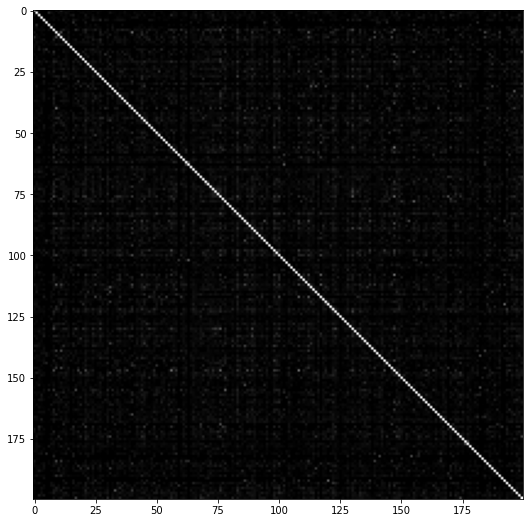

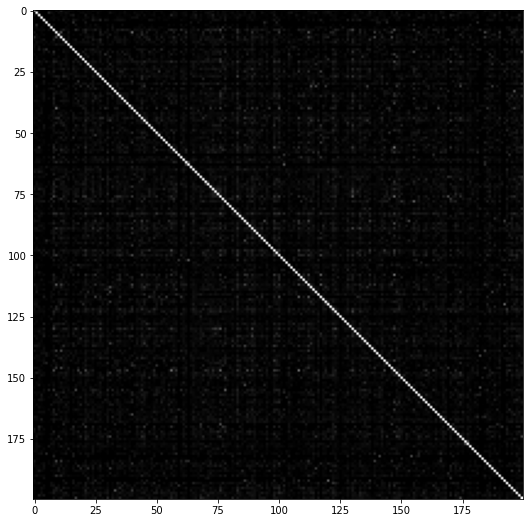

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

tfidf_vectors = tfidf.transform(data.head(200)["tokens"])

plt.figure(figsize=(9, 9))
_ = plt.imshow(cosine_similarity(tfidf_vectors, tfidf_vectors), cmap='gray')

plt.figure(figsize=(9, 9))
_ = plt.imshow(linear_kernel(tfidf_vectors, tfidf_vectors), cmap='gray')